In [1]:
!pip install scikit-learn
!pip install networkx
!pip install joblib
!pip install scipy
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install pandas
!pip install tqdm igraph

In [2]:
from time import perf_counter
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from joblib import Parallel, delayed
import os

import dag_utils as utils
from baselines import Nonneg_dagma, MetMulDagma
from TopoGreedy import TopoGreedy_TB, TopoGreedy_org, TopoGreedy_Fista
from baselines import colide_ev
from baselines import DAGMA_linear
from baselines import notears_linear
import dagu as dagu

PATH = './results/samples/'
SAVE = True 
SEED = 10
N_CPUS = 1  # Get number of available CPUs
np.random.seed(SEED)

/Users/hamedajorlou/miniforge3/envs/Greedytopo/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Experiment function
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def run_samples_exp(g, data_p, N_samples, exps, thr=.2, verb=False):
    shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = [np.zeros((len(N_samples), len(exps)))  for _ in range(9)]
    for i, n_samples in enumerate(N_samples):
        if g % N_CPUS == 0:
            print(f'Graph: {g+1}, samples: {n_samples}')

        # Create data
        data_p_aux = data_p.copy()
        data_p_aux['n_samples'] = n_samples

        # W_true, _, X, Theta_true = utils.simulate_sem(**data_p_aux)
        B_true = dagu.simulate_dag(d=data_p['n_nodes'], s0=data_p['edges'], graph_type=data_p['graph_type'])
        W_true, Theta_true = dagu.simulate_parameter(B_true, w_ranges=data_p['w_range'])
        X = dagu.simulate_linear_sem(W_true, n_samples, sem_type='gauss', noise_scale=data_p['var'])
        M = int((data_p['n_nodes'] + data_p['edges']*data_p['n_nodes'])*np.log(data_p['n_nodes']) )
        cov_X = X.T @ X / M
        X_std = utils.standarize(X)
        W_true_bin = utils.to_bin(W_true, thr)
        norm_W_true = np.linalg.norm(W_true)
        eig_vals = np.linalg.eigvals(Theta_true)

        for j, exp in enumerate(exps):
            X_aux = X_std if 'standarize' in exp.keys() and exp['standarize'] else X


            arg_aux = exp['args'].copy()
            if 'adapt_lamb' in exp.keys() and exp['adapt_lamb']:
                if 'lamb' in arg_aux.keys():
                    arg_aux['lamb'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lamb'])
                elif 'lambda1' in arg_aux.keys():
                    arg_aux['lambda1'] = get_lamb_value(data_p['n_nodes'], n_samples, arg_aux['lambda1'])

            if exp['model'] == notears_linear:
                t_init = perf_counter()
                W_est = notears_linear(X_aux, **arg_aux)
                t_end = perf_counter()

            else:

                model = exp['model'](**exp['init']) if 'init' in exp.keys() else exp['model']()
                t_init = perf_counter()
                model.fit(X, **arg_aux)
                t_end = perf_counter()
                W_est = model.W_est
                Theta_est = model.Theta_est if hasattr(model, 'Theta_est') else np.zeros_like(Theta_true)
                eig_vals_est = np.linalg.eigvals(Theta_est)


            if np.isnan(W_est).any():
                W_est = np.zeros_like(W_est)
                W_est_bin = np.zeros_like(W_est)
            else:
                W_est_bin = utils.to_bin(W_est, thr)
            
            W_est_bin = W_est_bin.T if exp['model'] == [TopoGreedy_TB, TopoGreedy_org, TopoGreedy_Fista] else W_est_bin
            W_est = W_est.T if exp['model'] == [TopoGreedy_TB, TopoGreedy_org, TopoGreedy_Fista] else W_est


            shd[i,j], tpr[i,j], fdr[i,j] = utils.count_accuracy(W_true_bin, W_est_bin)
            fscore[i,j] = f1_score(W_true_bin.flatten(), W_est_bin.flatten())
            err[i,j] = utils.compute_norm_sq_err(W_true, W_est, norm_W_true)
            acyc[i,j] = model.dagness(W_est) if hasattr(model, 'dagness') else 1
            Theta_est[i,j] = np.linalg.norm(Theta_est - Theta_true, 'fro') / (np.linalg.norm(Theta_true, 'fro') + 1e-8)
            runtime[i,j] = t_end - t_init
            dag_count[i,j] += 1 if utils.is_dag(W_est_bin) else 0
        
            if verb and (g % N_CPUS == 0):

                print(f'-{exp["leg"]}: shd {shd[i,j]}  -  err: {err[i,j]}  -  Theta diff: {Theta_est[i,j]:.3f}  -  time: {runtime[i,j]:.3f}')

    return shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est

In [14]:
n_dags = 8
N_samples = [1000, 2000, 3000, 4000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
  # TopoGreedy with more iterations but looser tolerance
  {'model': TopoGreedy, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': '^-', 'leg': 'Topogreedy'},
  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': False, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Logdet-fix'},

  # {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .1, 'iters_in': 10000,
  #  'iters_out': 10, 'beta': 5, 'tol': 1e-5}, 'init': {'acyclicity': 'matexp', 'primal_opt': 'fista'}, 'standarize': False,
  #  'adapt_lamb': True, 'fmt': 'x-', 'leg': 'MM-Matexp'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},

  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 4}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

In [9]:
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,   
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 1
Graph: 1, samples: 1000
-Topogreedy: shd 21.0  -  err: 0.12429370545747352  -  Theta diff: 0.259  -  time: 3.404
-CoLiDe-Fix: shd 0.0  -  err: 0.0042449716884052835  -  Theta diff: 1.000  -  time: 8.043
-DAGMA: shd 0.0  -  err: 0.004315217946240817  -  Theta diff: 1.000  -  time: 8.196
-NoTears: shd 6.0  -  err: 0.03155461593244837  -  Theta diff: 1.001  -  time: 1.427
Graph: 1, samples: 2000
-Topogreedy: shd 7.0  -  err: 0.032109723165765255  -  Theta diff: 0.155  -  time: 6.007
-CoLiDe-Fix: shd 0.0  -  err: 0.0018868259129843667  -  Theta diff: 1.000  -  time: 8.589
-DAGMA: shd 0.0  -  err: 0.001937037372660605  -  Theta diff: 1.000  -  time: 7.561
-NoTears: shd 3.0  -  err: 0.023945361392380533  -  Theta diff: 1.000  -  time: 2.364
Graph: 1, samples: 3000
-Topogreedy: shd 4.0  -  err: 0.0043043975208242975  -  Theta diff: 0.130  -  time: 4.729
-CoLiDe-Fix: shd 0.0  -  err: 0.0023761750444719473  -  Theta diff: 1.000  -  time: 9.034
-DAGMA: shd 0.0  -  err: 0.0024292

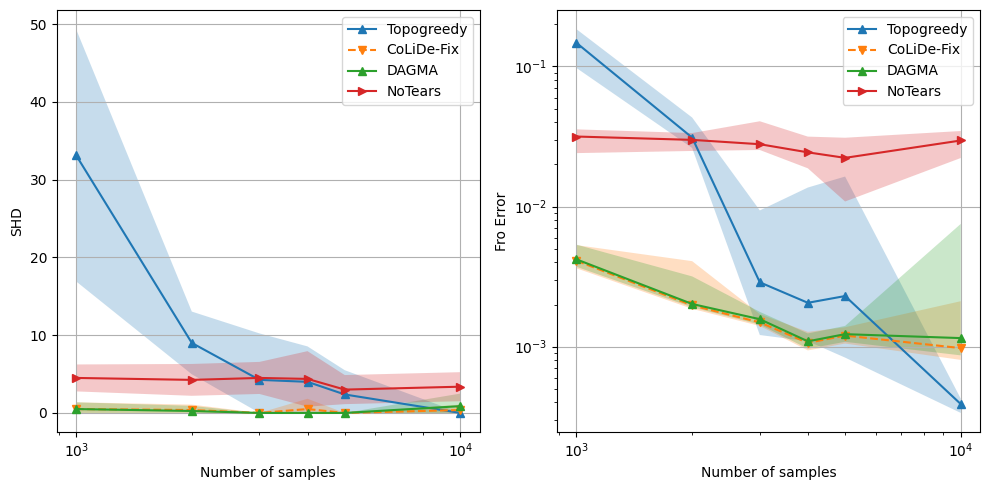

In [10]:
skip = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SHD', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
plt.savefig(PATH + f'samples_{N}N_{int(data_p["edges"]/N)}.png', dpi=300, bbox_inches='tight')

In [16]:
n_dags = 20
N_samples = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,   
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 1
Graph: 1, samples: 1000
-Topogreedy: shd 33.0  -  err: 0.18226495149645353  -  Theta diff: 0.239  -  time: 13.085
-CoLiDe-Fix: shd 3.0  -  err: 0.01319611325269811  -  Theta diff: 1.000  -  time: 13.576
-DAGMA: shd 3.0  -  err: 0.013221942500585226  -  Theta diff: 1.000  -  time: 15.069
-NoTears: shd 9.0  -  err: 0.08146825875112391  -  Theta diff: 1.000  -  time: 2.653
Graph: 1, samples: 2000
-Topogreedy: shd 77.0  -  err: 0.16640125375876985  -  Theta diff: 0.154  -  time: 11.191
-CoLiDe-Fix: shd 0.0  -  err: 0.0019644103617933216  -  Theta diff: 1.000  -  time: 9.750
-DAGMA: shd 0.0  -  err: 0.002066802718567188  -  Theta diff: 1.000  -  time: 9.523
-NoTears: shd 3.0  -  err: 0.03287668874434042  -  Theta diff: 1.000  -  time: 3.515
Graph: 1, samples: 3000
-Topogreedy: shd 7.0  -  err: 0.01778560991440308  -  Theta diff: 0.121  -  time: 5.775
-CoLiDe-Fix: shd 0.0  -  err: 0.0015080992751829428  -  Theta diff: 1.000  -  time: 9.647
-DAGMA: shd 0.0  -  err: 0.00154777

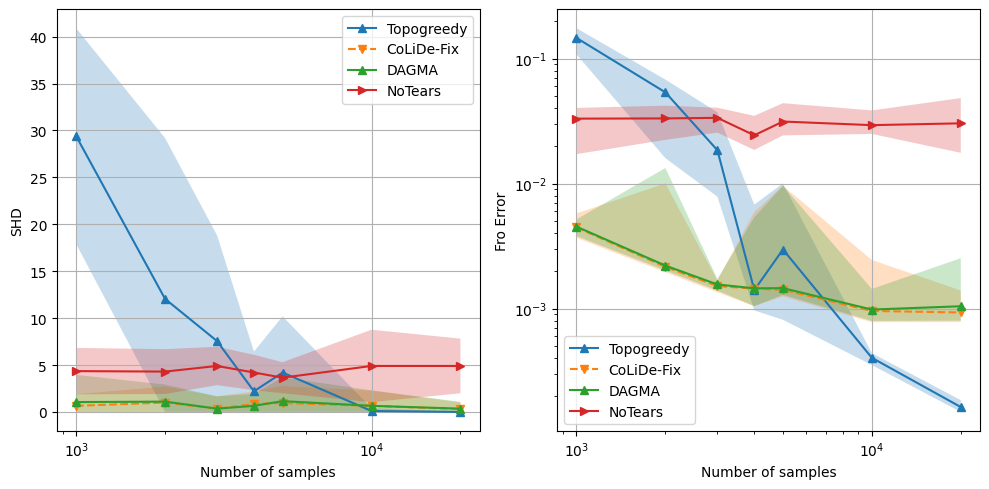

In [17]:

skip = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SHD', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
plt.savefig(PATH + f'samples_{N}N_{int(data_p["edges"]/N)}.png', dpi=300, bbox_inches='tight')

In [18]:
n_dags = 20
N_samples = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
N = 200
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,   
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 1
Graph: 1, samples: 1000
-Topogreedy: shd 740.0  -  err: 1.9990309549638223  -  Theta diff: 0.436  -  time: 47.286
-CoLiDe-Fix: shd 3.0  -  err: 0.014339723603921939  -  Theta diff: 1.000  -  time: 31.717
-DAGMA: shd 3.0  -  err: 0.014332200917889797  -  Theta diff: 1.000  -  time: 30.407
-NoTears: shd 8.0  -  err: 0.04018778158953775  -  Theta diff: 1.000  -  time: 9.905
Graph: 1, samples: 2000
-Topogreedy: shd 45.0  -  err: 0.16172456268664676  -  Theta diff: 0.247  -  time: 27.805
-CoLiDe-Fix: shd 1.0  -  err: 0.004323060539260696  -  Theta diff: 1.000  -  time: 35.790
-DAGMA: shd 1.0  -  err: 0.004359537481065588  -  Theta diff: 1.000  -  time: 29.629
-NoTears: shd 8.0  -  err: 0.028692249331648146  -  Theta diff: 1.000  -  time: 8.657
Graph: 1, samples: 3000
-Topogreedy: shd 19.0  -  err: 0.062197994137324714  -  Theta diff: 0.182  -  time: 39.899
-CoLiDe-Fix: shd 1.0  -  err: 0.003737891317732666  -  Theta diff: 1.000  -  time: 29.898
-DAGMA: shd 1.0  -  err: 0.00

/Users/hamedajorlou/Documents/Greedy_Alg/TopoGreedy.py:41: RuntimeWarning: overflow encountered in multiply
  theta_aux[j, :] -= a_i[j] * a_i
/Users/hamedajorlou/Documents/Greedy_Alg/TopoGreedy.py:38: RuntimeWarning: invalid value encountered in add
  theta_aux[:, i] += a_i
/Users/hamedajorlou/Documents/Greedy_Alg/TopoGreedy.py:39: RuntimeWarning: invalid value encountered in add
  theta_aux[i, :] += a_i
/Users/hamedajorlou/Documents/Greedy_Alg/TopoGreedy.py:41: RuntimeWarning: invalid value encountered in multiply
  theta_aux[j, :] -= a_i[j] * a_i


-Topogreedy: shd 198.0  -  err: 1.0  -  Theta diff: 0.432  -  time: 23.850
-CoLiDe-Fix: shd 0.0  -  err: 0.005670695213268852  -  Theta diff: 1.000  -  time: 30.443
-DAGMA: shd 0.0  -  err: 0.005690398490939275  -  Theta diff: 1.000  -  time: 34.499
-NoTears: shd 8.0  -  err: 0.024250810085931825  -  Theta diff: 1.000  -  time: 6.151
Graph: 2, samples: 2000
-Topogreedy: shd 78.0  -  err: 0.11410532724995505  -  Theta diff: 0.248  -  time: 37.096
-CoLiDe-Fix: shd 1.0  -  err: 0.003832669121095618  -  Theta diff: 1.000  -  time: 32.834
-DAGMA: shd 1.0  -  err: 0.0039054770877629415  -  Theta diff: 1.000  -  time: 30.497
-NoTears: shd 9.0  -  err: 0.03472495658916352  -  Theta diff: 1.000  -  time: 11.906
Graph: 2, samples: 3000
-Topogreedy: shd 16.0  -  err: 0.06911138132314769  -  Theta diff: 0.188  -  time: 27.616
-CoLiDe-Fix: shd 2.0  -  err: 0.005030466059575353  -  Theta diff: 1.000  -  time: 31.079
-DAGMA: shd 2.0  -  err: 0.005064675760132608  -  Theta diff: 1.000  -  time: 29.867

SAVED in file: ./results/samples/samples_200N_2


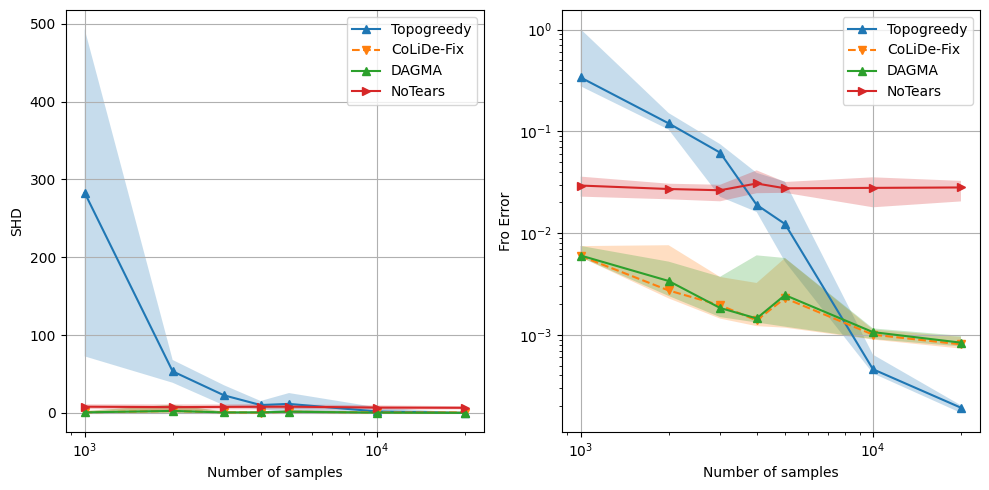

In [22]:
if SAVE:
    import os
    os.makedirs(PATH, exist_ok=True)
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

skip = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SHD', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
plt.savefig(PATH + f'samples_{N}N_{int(data_p["edges"]/N)}.png', dpi=300, bbox_inches='tight')

In [4]:
from TopoGreedy import TopoGreedy, Topo
import numpy as np
n_dags = 8
N_samples = [1000, 2000, 3000, 4000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
  # TopoGreedy with more iterations but looser tolerance
  {'model': TopoGreedy, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': '^-', 'leg': 'Topogreedy'},
  # {'model': Topo, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': 'o-', 'leg': 'Topogreedy1'},
  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': False, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Logdet-fix'},

  # {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .1, 'iters_in': 10000,
  #  'iters_out': 10, 'beta': 5, 'tol': 1e-5}, 'init': {'acyclicity': 'matexp', 'primal_opt': 'fista'}, 'standarize': False,
  #  'adapt_lamb': True, 'fmt': 'x-', 'leg': 'MM-Matexp'},

  # Colide
  {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
   'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},

  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
  {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
   'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
  {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 4}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

ImportError: cannot import name 'Topo' from 'TopoGreedy' (/Users/hamedajorlou/Documents/Greedy_Alg/TopoGreedy.py)

In [7]:
n_dags = 20
N_samples = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 4*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,   
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 1
Graph: 1, samples: 1000
-Topogreedy: shd 388.0  -  err: 1.6990688005096506  -  Theta diff: 0.221  -  time: 18.090
-CoLiDe-Fix: shd 4.0  -  err: 0.02063545987911467  -  Theta diff: 1.000  -  time: 14.901
-DAGMA: shd 1.0  -  err: 0.006985276991564197  -  Theta diff: 1.000  -  time: 14.727
-NoTears: shd 34.0  -  err: 0.14000682050369792  -  Theta diff: 1.000  -  time: 8.003
Graph: 1, samples: 2000
-Topogreedy: shd 252.0  -  err: 1.3025481679040172  -  Theta diff: 0.135  -  time: 17.928
-CoLiDe-Fix: shd 7.0  -  err: 0.039067557497264815  -  Theta diff: 1.000  -  time: 10.277
-DAGMA: shd 4.0  -  err: 0.034534207846666665  -  Theta diff: 1.000  -  time: 9.852
-NoTears: shd 18.0  -  err: 0.08738237456858433  -  Theta diff: 1.000  -  time: 22.597
Graph: 1, samples: 3000
-Topogreedy: shd 40.0  -  err: 0.12619875515457946  -  Theta diff: 0.114  -  time: 16.435
-CoLiDe-Fix: shd 2.0  -  err: 0.005211963250138514  -  Theta diff: 1.000  -  time: 9.434
-DAGMA: shd 2.0  -  err: 0.0052

SAVED in file: ./results/samples/samples_100N_4


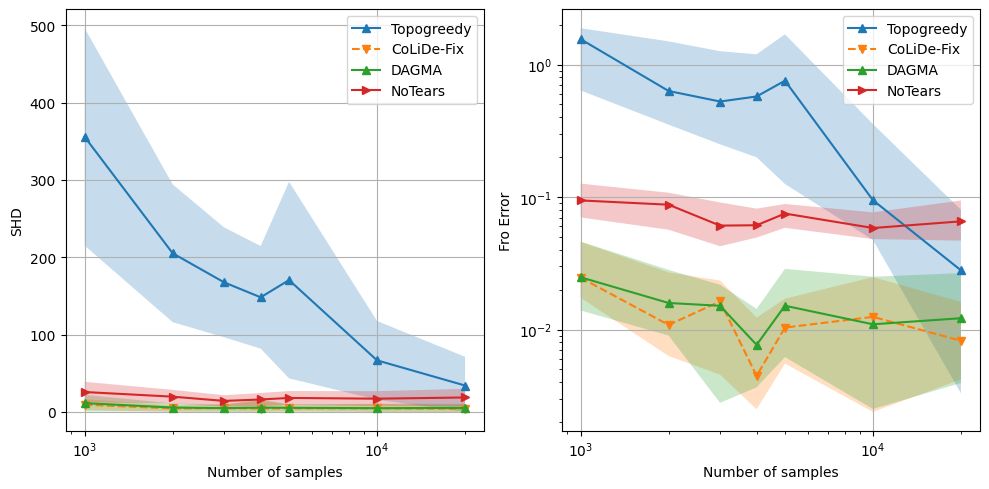

In [8]:
if SAVE:
    import os
    os.makedirs(PATH, exist_ok=True)
    file_name = PATH + f'samples_{N}N_{int(data_p["edges"]/N)}'
    np.savez(file_name, shd=shd, tpr=tpr, fdr=fdr, fscore=fscore, err=err,
             acyc=acyc, runtime=runtime, dag_count=dag_count, exps=Exps,
             xvals=N_samples)
    print('SAVED in file:', file_name)

skip = []

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
utils.plot_data(axes[0], shd, Exps, N_samples, 'Number of samples', 'SHD', skip,
                agg='mean', deviation='std', alpha=0.25)
utils.plot_data(axes[1], err, Exps, N_samples, 'Number of samples', 'Fro Error', skip,
                agg='median', deviation='prctile', alpha=0.25, plot_func='loglog')
plt.tight_layout()
plt.savefig(PATH + f'samples_{N}N_{int(data_p["edges"]/N)}.png', dpi=300, bbox_inches='tight')

In [14]:
from TopoGreedy import TopoGreedy_TB, TopoGreedy_org, TopoGreedy_Fista, TopoGreedy
import numpy as np
n_dags = 8
N_samples = [1000, 2000, 3000, 4000, 5000, 10000]

# DEFINE EXPERIMENTS
Exps = [
  # TopoGreedy with more iterations but looser tolerance
  # {'model': TopoGreedy_TB, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': '^-', 'leg': 'Topogreedy_TB'},
  # {'model': TopoGreedy_org, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': 'o-', 'leg': 'Topogreedy_org'},
  # {'model': TopoGreedy_Fista, 'args': {'max_iter': 10, 'tol': 1e-4}, 'fmt': 'x-', 'leg': 'Topogreedy_Fista'},
  {'model': TopoGreedy, 'args': {'max_iter': 10, 'tol': 1e-4}, 'standarize': True, 'fmt': 'v-', 'leg': 'Topogreedy'},
  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': 1e-1,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': True, 'standarize': False, 'fmt': 'o-', 'leg': 'MM-Logdet'},

  # {'model': MetMulDagma, 'args': {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': .05,
  #  'iters_in': 10000, 'iters_out': 10, 'beta': 2}, 'init': {'primal_opt': 'adam', 'acyclicity': 'logdet'},
  #  'adapt_lamb': False, 'standarize': False, 'fmt': 'o--', 'leg': 'MM-Logdet-fix'},

  # {'model': MetMulDagma, 'args': {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .1, 'iters_in': 10000,
  #  'iters_out': 10, 'beta': 5, 'tol': 1e-5}, 'init': {'acyclicity': 'matexp', 'primal_opt': 'fista'}, 'standarize': False,
  #  'adapt_lamb': True, 'fmt': 'x-', 'leg': 'MM-Matexp'},

  # Colide
#   {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
#    'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': 'v--', 'leg': 'CoLiDe-Fix'},

  # {'model': colide_ev, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .7], 'warm_iter': 2e4,
  #  'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'adapt_lamb': True, 'fmt': 'v-', 'leg': 'CoLiDe'},

  # DAGMA
#   {'model': DAGMA_linear, 'init': {'loss_type': 'l2'}, 'args': {'lambda1': .05, 'T': 4, 's': [1.0, .9, .8, .8],
#    'warm_iter': 2e4, 'max_iter': 7e4, 'lr': .0003}, 'standarize': False, 'fmt': '^-', 'leg': 'DAGMA'},

  # NoTears
#   {'model': notears_linear, 'args': {'loss_type': 'l2', 'lambda1': .1, 'max_iter': 4}, 'standarize': False,  'fmt': '>-', 'leg': 'NoTears'},
]

In [17]:
n_dags = 20
N_samples = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 4*N,
    'edge_type': 'negative',
    'w_range': ((-1.5, -0.5), (0.5, 1.5)),
    'var': 1,   
}

shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est =\
      [np.zeros((n_dags, len(N_samples), len(Exps)))  for _ in range(9)]

print('CPUs employed:', N_CPUS)

t_init = perf_counter()
results = Parallel(n_jobs=N_CPUS)(delayed(run_samples_exp)
                                  (g, data_p, N_samples, Exps, thr, verb) for g in range(n_dags))
t_end = perf_counter()
print(f'----- Solved in {(t_end-t_init)/60:.3f} minutes -----')
shd, tpr, fdr, fscore, err, acyc, runtime, dag_count, Theta_est = zip(*results)

CPUs employed: 1
Graph: 1, samples: 1000
-Topogreedy: shd 109.0  -  err: 0.35766757159577506  -  Theta diff: 0.228  -  time: 18.967
Graph: 1, samples: 2000
-Topogreedy: shd 69.0  -  err: 0.14818126944016727  -  Theta diff: 0.141  -  time: 18.939
Graph: 1, samples: 3000
-Topogreedy: shd 80.0  -  err: 0.16763064709095704  -  Theta diff: 0.112  -  time: 16.758
Graph: 1, samples: 4000


KeyboardInterrupt: 

In [4]:
!pip install seaborn

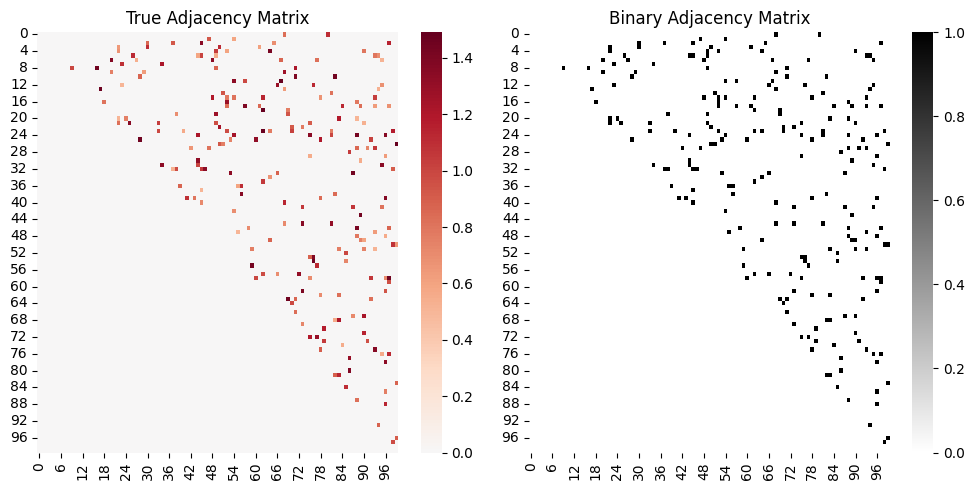

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from dag_utils import create_dag, simulate_sem
n_dags = 20
N_samples = [1000, 2000, 3000, 4000, 5000, 10000, 20000]
N = 100
thr = .2
verb = True
data_p = {
    'n_nodes': N,
    'graph_type': 'ER',
    'edges': 2*N,
    'edge_type': 'positive',
    'w_range': (0.5, 1.5),
    'var': 1,   
}
# Generate one DAG using same parameters as experiment
A_true, dag, X, Theta_true = simulate_sem(n_nodes=N, 
                                        n_samples=1000,
                                        graph_type='er',
                                        edges=2*N,
                                        edge_type='positive',
                                        w_range=(0.5, 1.5),
                                        noise_type='normal',
                                        var=1,
                                        permute=False)

# Plot the adjacency matrix 
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.heatmap(A_true, cmap='RdBu_r', center=0)
plt.title('True Adjacency Matrix')

plt.subplot(122) 
sns.heatmap((A_true != 0).astype(int), cmap='binary')
plt.title('Binary Adjacency Matrix')

plt.tight_layout()
plt.show()



In [7]:
from TopoGreedy import estimate_adjacency_matrix
import numpy as np



A_est = estimate_adjacency_matrix(Theta_true, N)
print(A_est)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.14522775 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.97101209 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


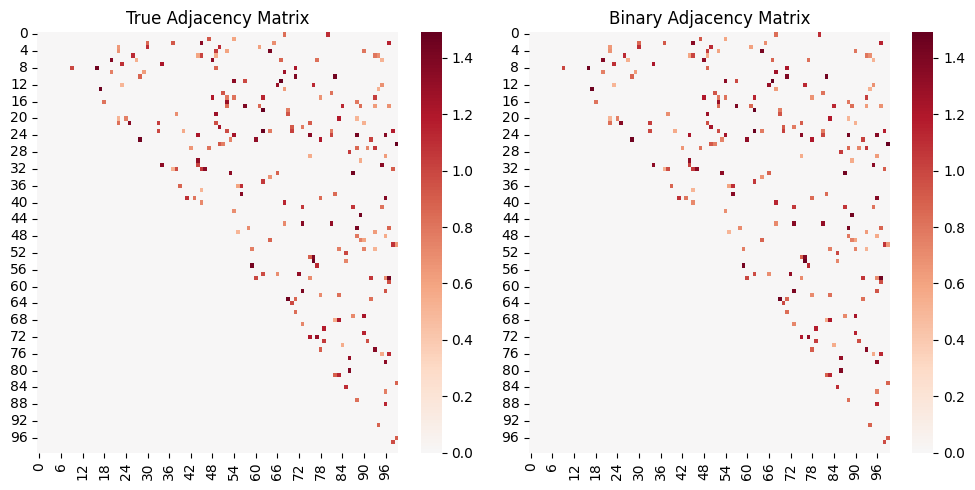

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from dag_utils import create_dag, simulate_sem

# # Generate one DAG using same parameters as experiment
# A_true, dag, X, Theta_true = simulate_sem(n_nodes=N, 
#                                         n_samples=1000,
#                                         graph_type='er',
#                                         edges=2*N,
#                                         edge_type='positive',
#                                         w_range=(0.5, 1.5),
#                                         noise_type='normal',
#                                         var=1,
#                                         permute=False)

# Plot the adjacency matrix 
plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.heatmap(A_true, cmap='RdBu_r', center=0)
plt.title('True Adjacency Matrix')

plt.subplot(122) 
sns.heatmap(A_est, cmap='RdBu_r', center=0)
plt.title('Binary Adjacency Matrix')

plt.tight_layout()
plt.show()

